In [2]:
pip install yfinance

     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     --------------- --------------------- 409.6/948.2 kB 12.5 MB/s eta 0:00:01
     ------------------------------------  942.1/948.2 kB 14.8 MB/s eta 0:00:01
     ------------------------------------- 948.2/948.2 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/101.1 kB ? eta -:--:--
   ---------------------------------------- 101.1/101.1 kB 2.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=138987 sha256=85426c1b038e851f9b4bd1a788dd56983d75f6cb3810076d90f4c121f3e32f71
  Stored in directory: c:\users\valquiria.pires\appdat

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


In [44]:


# 1. Coleta de Dados
symbol = 'TSLA'   #TESLA
start_date = '2015-01-01'
end_date = '2024-07-01'

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Open', 'Close']]





[*********************100%***********************]  1 of 1 completed


In [45]:
df.head()

Price,Open,Close
Ticker,TSLA,TSLA
Date,,
2015-01-02 00:00:00+00:00,14.858000,14.620667
2015-01-05 00:00:00+00:00,14.303333,14.006000
2015-01-06 00:00:00+00:00,14.004000,14.085333
2015-01-07 00:00:00+00:00,14.223333,14.063333
2015-01-08 00:00:00+00:00,14.187333,14.041333


In [46]:
# 2. Pré-processamento
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [47]:
# Função para criar janelas temporais
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(df_scaled, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))



In [48]:
# Divisão dos dados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1886, 30, 1)
(1886,)
(472, 30, 1)
(472,)


In [49]:


# 3. Modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



Epoch 1/50
48/48 [==============================] - 10s 58ms/step - loss: 0.0137 - val_loss: 0.0015
Epoch 2/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11

In [50]:
# 4. Avaliação
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 7ms/step - loss: 0.0012


0.001220526173710823

In [51]:
# Predições
y_pred = model.predict(X_test)


In [55]:
y_test_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(root_mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 7.51
Root Mean Squared Error (RMSE): 3.74


In [53]:
mse = root_mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')

MSE: 0.03493603220626052
RMSE: 0.1869118300329343
MAPE: 38368497733.547386


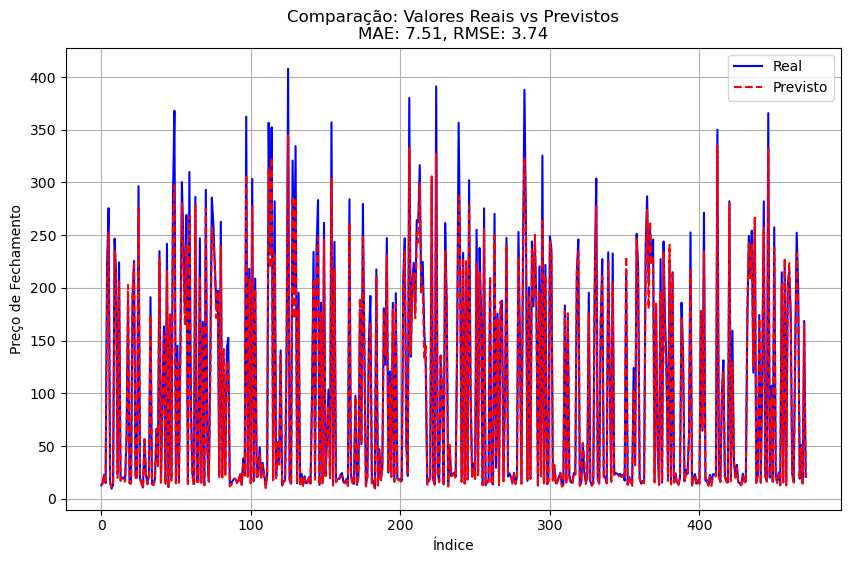

In [56]:
import matplotlib.pyplot as plt

# Gerar o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Real", color='blue')
plt.plot(y_pred_rescaled, label="Previsto", color='red', linestyle='dashed')
plt.title(f'Comparação: Valores Reais vs Previstos\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### Salvando o modelo

In [ ]:
model.save("stock_price_predictor.h5")
import joblib
joblib.dump(scaler, 'scaler.pkl')